# Проект для «Викишоп» c BERT

Интернет-магазин «Викишоп» запускает новый сервис. Теперь пользователи могут редактировать и дополнять описания товаров, как в вики-сообществах. То есть клиенты предлагают свои правки и комментируют изменения других. Магазину нужен инструмент, который будет искать токсичные комментарии и отправлять их на модерацию. 

Обучите модель классифицировать комментарии на позитивные и негативные. В вашем распоряжении набор данных с разметкой о токсичности правок.

Постройте модель со значением метрики качества *F1* не меньше 0.75. 

**Инструкция по выполнению проекта**

1. Загрузите и подготовьте данные.
2. Обучите разные модели. 
3. Сделайте выводы.


**Описание данных**

Данные находятся в файле `toxic_comments.csv`. Столбец *text* в нём содержит текст комментария, а *toxic* — целевой признак.

In [1]:
# Install pytorch with CUDA enabled
!pip install torch -q --index-url https://download.pytorch.org/whl/cu118
!pip install transformers -q

In [2]:
# Импорт библиотек, классов и функций
import os
import gc
import warnings

import pandas as pd
import torch
import numpy as np
import joblib
import seaborn as sns
import matplotlib.pyplot as plt
import lightgbm as lgb
import catboost as cb
from tqdm.notebook import tqdm
from transformers import AutoTokenizer, AutoModel
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import RandomizedSearchCV
from sklearn.model_selection import cross_val_score
from sklearn.metrics import f1_score, confusion_matrix

In [3]:
# Определение констант и настройка
RANDOM_STATE = 42
CV = 5
SCORING = "f1"
MODEL_DIR = "models"

warnings.filterwarnings('ignore')

## Подготовка

In [4]:
# Загрузка данных
try:
    data = pd.read_csv("toxic_comments.csv", index_col=0)
except:
    data = pd.read_csv("https://code.s3.yandex.net/datasets/toxic_comments.csv", index_col=0)
data.info()
data

<class 'pandas.core.frame.DataFrame'>
Int64Index: 159292 entries, 0 to 159450
Data columns (total 2 columns):
 #   Column  Non-Null Count   Dtype 
---  ------  --------------   ----- 
 0   text    159292 non-null  object
 1   toxic   159292 non-null  int64 
dtypes: int64(1), object(1)
memory usage: 3.6+ MB


,text,toxic
0,Explanation\nWhy the edits made under my usern...,0
1,D'aww! He matches this background colour I'm s...,0
2,"Hey man, I'm really not trying to edit war. It...",0
3,"""\nMore\nI can't make any real suggestions on ...",0
4,"You, sir, are my hero. Any chance you remember...",0
...,...,...
159446,""":::::And for the second time of asking, when ...",0
159447,You should be ashamed of yourself \n\nThat is ...,0
159448,"Spitzer \n\nUmm, theres no actual article for ...",0
159449,And it looks like it was actually you who put ...,0


Датасет содержит 159'292 записи, пропуски отсутствуют. Датасет на английском языке, соответственно нужно применять модель BERT для английского. Оценим распределение целевого признака.

In [5]:
data["toxic"].value_counts()

0    143106
1     16186
Name: toxic, dtype: int64

По проекту стоит задача бинарной классификации, при этом целевой признак имеет сильный дисбаланс классов в пользу позитивных комментариев. При обучении модели необходимо учитывать дисбаланс классов. Подготовим признаки для обучения моделей на основе комментариев из предоставленного датасета посредтсвом предварительно обученной модели Toxic-BERT, которая представляет собой специально дообученную на токсичных текстах (оскорбления, угрозы, ненависть и т.д.) модель BERT и применяется для задач кластеризации таких текстов.

In [6]:
# Проверяем наличие CUDA в GPU
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")
# Инициализация токенизатора и модели Toxic-BERT
tokenizer = AutoTokenizer.from_pretrained('unitary/toxic-bert', clean_up_tokenization_spaces=False)
bert_model = AutoModel.from_pretrained('unitary/toxic-bert').to(device)

Using device: cuda


Так как получение эмбеддингов обученной моделью Toxic-BERT занимает достаточно много времени, лучше делать это посредством GPU, что при оптимальном подборе размера батча позволит значительно ускорить процесс. Чем производительней аппаратное обеспечение - больше графической памяти и процессоров CUDA, тем больший размер батчей можно использовать, что ускоряет преобразование текста в векорное представление.

In [7]:
# Функция для получения эмбеддингов с Toxic-BERT
def get_bert_embeddings(texts, batch_size=100):
    embeddings = []
    for i in tqdm(range(0, len(texts), batch_size), desc="Processing batches"):
        batch_texts = texts[i:i + batch_size]
        inputs = tokenizer(
            batch_texts, return_tensors='pt', padding=True, truncation=True, max_length=512
        ).to(device)
        with torch.no_grad():  # Отключаем градиенты, так как модель не обучается
            outputs = bert_model(**inputs)
        batch_embeddings = outputs.last_hidden_state[:, 0, :].cpu().numpy()
        embeddings.append(batch_embeddings)
        # Очистка памяти после обработки батча
        del inputs, outputs
        if device == "cuda":
            torch.cuda.empty_cache()
    del batch_texts, batch_embeddings
    return np.vstack(embeddings)

In [8]:
%%time
# Получение эмбеддингов
filename = "embedding.npy"
if os.path.isfile(filename): # Если уже получены
    X = np.load(filename)
else: # Если не получены
    X = get_bert_embeddings(data["text"].to_list())
    np.save("embedding.npy", X)
print("Размер данных для обучения:", X.shape)

Processing batches:   0%|          | 0/1593 [00:00<?, ?it/s]

Размер данных для обучения: (159292, 768)
CPU times: total: 3h 23s
Wall time: 3h 9min 20s


In [9]:
# Целевой признак
y = data["toxic"].to_numpy()

In [10]:
# Разделение на тренировочную и тестовую выборки со стратификацией
X_train, X_test, y_train, y_test = train_test_split(X, y, stratify=y, random_state=RANDOM_STATE)

# Очистка памяти перед обучением
del tokenizer, bert_model, X, y, data
torch.cuda.empty_cache()
gc.collect()

print("Размер тренировочной выборки:", X_train.shape)
print("Размер тестовой выборки:", X_test.shape)

Размер тренировочной выборки: (119469, 768)
Размер тестовой выборки: (39823, 768)


## Обучение

Для предсказания результатов проверим различные модели, решающие задачи классификации - из простых моделей выберем логистическую регрессию, а из ансамблевых методов - RandomForest, LightGBM и CatBoost. В качестве метрики будет использована F1-мера, которая представляет собой среднее гармоническое от точности (precision) и полноты (recall) и неплохо оценивает качество предсказаний.

Модели для проверки:
1. Логистическая регрессия (Logistic Regression);
2. Random Forest;
3. Light GBM.
4. CatBoost.

Метрики модели:
- F1-мера (F1-score).

Для оценки модели будет использоваться кросс-валидация на тренировочной выборке. Подбор гиперпараметров будет производиться для всех моделей посредством RandomizedSearchCV библиотеки scikit-learn, при этом для ускорения кросс-валидации модель CatBoost желательно запускать на GPU.

In [11]:
# Определение моделей и значений для подбора гиперпараметров
models = {
    "Logistic_Regression": {
        "model": LogisticRegression(
            random_state=RANDOM_STATE, class_weight="balanced"
        ),
        "params": {
            "C": [0.01, 0.1, 1, 10, 100],
            "solver": ["liblinear", "lbfgs", "saga"],
            "max_iter": [500, 1000]
        },
        "file": "lr.pkl",
        "rs_jobs": -1,
        "rs_iter": 16
    },
    "Random_Forest": {
        "model": RandomForestClassifier(
            random_state=RANDOM_STATE, n_jobs=-1, class_weight="balanced"
        ),
        "params": {
            'n_estimators': [500, 1000],
            'max_depth': [5, 10, 20],
            'min_samples_split': [2, 5, 10],
            'min_samples_leaf': [1, 2, 4]
        },
        "file": "rf.pkl",
        "rs_jobs": None,
        "rs_iter": 8
    },
    "LightGBM": {
        "model": lgb.LGBMClassifier(
            random_state=RANDOM_STATE, n_jobs=-1, 
            class_weight="balanced", verbosity=-1
        ),
        "params": {
            'n_estimators': [500, 1000],
            'learning_rate': [0.01, 0.05, 0.1],
            'num_leaves': [31, 63, 127],
            'max_depth': [3, 5, 10]
        },
        "file": "lgb.pkl",
        "rs_jobs": None,
        "rs_iter": 16
    },
    "CatBoost": {
        "model": cb.CatBoostClassifier(
            random_seed=RANDOM_STATE, thread_count=-1, 
            auto_class_weights="Balanced", 
            logging_level="Silent", 
            task_type="GPU" if torch.cuda.is_available() else "CPU",
            devices="0" if torch.cuda.is_available() else None
        ),
        "params": {
            'iterations': [500, 1000],
            'depth': [4, 6, 8],
            'learning_rate': [0.01, 0.05, 0.1],
            'l2_leaf_reg': [1, 3, 5]
        },
        "file": "cb.pkl",
        "rs_jobs": None,
        "rs_iter": 16
    }
}

In [12]:
# Подготовка переменной для результатов кросс-валидации
results_file = MODEL_DIR + "/" + "results.json"
if os.path.isfile(results_file): # Загрузка результатов, если они получены
    results = pd.read_json(results_file)
else: # Подготовка переменной для результатов, если они еще не получены
    results = pd.DataFrame()
    for model in models.keys():
        results.loc[model, "f1_score"] = None
        results.loc[model, "fit_time"] = None
        results.loc[model, "model_file"] = None
        results.loc[model, "params"] = None
    del model

In [13]:
%%time
# Проверка результатов и подбор гиперпараметров в случае их отсутствия
pb = tqdm(total=results.shape[0])
for name, model_result in results.iterrows():
    pb.set_description(f"Подбор гиперпараметров модели {name}")
    if (
        pd.isnull(model_result["model_file"]) or 
        (not os.path.isfile(model_result["model_file"]))
    ):
        # Подбор гиперпараметров для модели с кросс-валидацией
        rs = RandomizedSearchCV(
            models[name]["model"], models[name]["params"], scoring=SCORING, 
            cv=CV, n_iter=16, n_jobs=models[name]["rs_jobs"], verbose=0,
            random_state=RANDOM_STATE, refit=True)
        
        rs.fit(X_train, y_train)

        # сохранение лучшей модели
        os.makedirs(MODEL_DIR, exist_ok=True) # создание директории, если её ещё нет
        filename = MODEL_DIR + "/" + models[name]["file"]
        with open(filename, "wb") as fd:
            joblib.dump(rs.best_estimator_, fd)

        # сохранение результатов кросс-валидации в переменную
        results.loc[name, "f1_score"] = rs.best_score_
        results.loc[name, "fit_time"] = rs.cv_results_["mean_fit_time"][rs.best_index_]
        results.loc[name, "model_file"] = filename
        results.loc[name, "params"] = str(rs.best_params_)
    print(f"Лучшие гиперпараметры модели {name}:", results.loc[name, 'params'])
    results.to_json(results_file)
    pb.update(1)
pb.close()

  0%|          | 0/4 [00:00<?, ?it/s]

Лучшие гиперпараметры модели Logistic_Regression: {'solver': 'saga', 'max_iter': 1000, 'C': 10}
Лучшие гиперпараметры модели Random_Forest: {'n_estimators': 500, 'min_samples_split': 2, 'min_samples_leaf': 4, 'max_depth': 20}
Лучшие гиперпараметры модели LightGBM: {'num_leaves': 63, 'n_estimators': 1000, 'max_depth': 10, 'learning_rate': 0.05}
Лучшие гиперпараметры модели CatBoost: {'learning_rate': 0.05, 'l2_leaf_reg': 3, 'iterations': 1000, 'depth': 8}
CPU times: total: 2d 3h 32min 8s
Wall time: 4h 27min 55s


In [14]:
# Вывод результатов
results.sort_values("f1_score", ascending=False).style.background_gradient(
    cmap=sns.diverging_palette(250, 25, as_cmap=True), 
    subset=list(["f1_score", "fit_time"])
).format({"f1_score": "{:.3f}", "fit_time": "{:.2f}"})

,f1_score,fit_time,model_file,params
LightGBM,0.947,63.07,models/lgb.pkl,"{'num_leaves': 63, 'n_estimators': 1000, 'max_depth': 10, 'learning_rate': 0.05}"
Random_Forest,0.945,157.85,models/rf.pkl,"{'n_estimators': 500, 'min_samples_split': 2, 'min_samples_leaf': 4, 'max_depth': 20}"
CatBoost,0.941,53.13,models/cb.pkl,"{'learning_rate': 0.05, 'l2_leaf_reg': 3, 'iterations': 1000, 'depth': 8}"
Logistic_Regression,0.926,256.24,models/lr.pkl,"{'solver': 'saga', 'max_iter': 1000, 'C': 10}"


## Выводы

По результатам кросс-валидации на тестовых данных лучшую метрику показывает модель LightGBM, довольно близкие результаты у модели Random Forest и с небольшим отставанием результаты модели CatBoost. Стоит отметить, что при обучении на GPU CatBoost показывает наилучшие результаты по скорости. Самое низкое значение метрики у модели Логистической регрессии. Оценим лучшую модель на тестовых данных.

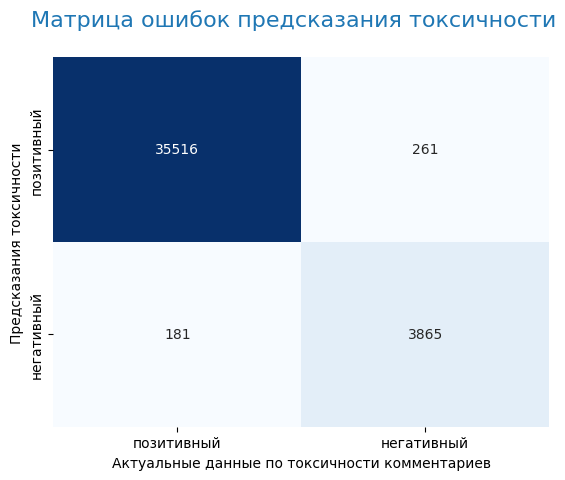

Метрика F1-score для тестовой выборки: 0.946


In [15]:
best_result = results.sort_values("f1_score", ascending=False).iloc[0]
with open(best_result["model_file"], "rb") as fd:
    model = joblib.load(fd)
y_pred = model.predict(X_test)
ax = sns.heatmap(
    confusion_matrix(y_test, y_pred),
    annot=True, fmt="d", cmap="Blues", cbar=False,
    xticklabels=["позитивный", "негативный"],
    yticklabels=["позитивный", "негативный"],
)
ax.set_yticklabels(ax.get_yticklabels(), va="center")
plt.suptitle("Матрица ошибок предсказания токсичности", size=16, color="C0")
plt.xlabel("Актуальные данные по токсичности комментариев")
plt.ylabel("Предсказания токсичности")
plt.show()
print(f"Метрика F1-score для тестовой выборки: {f1_score(y_test, y_pred):.3f}")

По тестовой выборке можно отметить, что модель очень хорошо предсказывает позитивные комментарии - всего 181 комментарий был ошибочно предсказан как негативный, а 35'516 комментариев предсказаны верно. Отношение верно предсказанных комментариев составляет 99,5% от всех позитивных комментариев.  По негативным комментариям ситуация значительно хуже - 261 комментарий предсказан как позитивный, а 3'865 предсказаны верно, что составляет порядка 93.7% от всех негативных комментариев. Метрика F1 для тестовой выборки составляет 0.946, что довольно близко к значениям при кросс-валидации.

Использование предварительно обученных моделей BERT качественно влияют на результаты предсказаний моделей в задачах машинного обучения для текстов. Модель BERT создает векторное представление слов с учетом их контекста, отношений между словами и их семантики, что существенно лучше более простых подходов. Даже базовые модели машинного обучения показывают высокие результаты предсказаний, а применение ансамблевых методов может улучшить результаты. 

Однако стоит отметить, что применение BERT значительно увеличивает требования к вычислительным ресурсам, желательно использовать производительные GPU для подготовки датасета перед обучением моделей. Также при использовании BERT размерность признаков для обучения вероятнее всего будет существенно выше, чем при применении подхода, такого как TF-IDF при котором используется только частота встречи слов. Таким образом, применение BERT требует значительных вычислительных ресурсов как для подготовки датасета, так и для работы моделей.